In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import keras.backend as K
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import word2vec
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import time
import os

Using TensorFlow backend.


In [2]:
data = pd.read_csv('baza/1429_1.csv', parse_dates=True)

C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Pretprocesiranje teksta je isto kao u glavnom main-u .

Izdvajamo tekstualne podatke i njihove ocene iz baze, pretprocesiramo tekst...

In [3]:
currently = data[['reviews.text','reviews.rating']]
reduced = currently.dropna(how='any') # Brisemo svaki red koji ima bilo gde NaN vrednost
print(f'Bez NaN vrednosti imamo {reduced.shape[0]} instanci')

reduced = reduced.replace([1,2,3], 0)
reduced = reduced.replace([4,5], 1)
print('\nTekstove ocenjene sa 1,2,3 prepoznavacemo kao negativan sentiment')
print('Tekstove ocenjene sa 4,5 prepoznavacemo kao pozitivan sentiment\n')

Bez NaN vrednosti imamo 34626 instanci

Tekstove ocenjene sa 1,2,3 prepoznavacemo kao negativan sentiment
Tekstove ocenjene sa 4,5 prepoznavacemo kao pozitivan sentiment



In [4]:
print(reduced["reviews.text"][5])

#smanji sva slova
reduced["reviews.text"] = reduced["reviews.text"].str.lower()
print(f'\nSlova su smanjena : \n{reduced["reviews.text"][5]}')

#tokenization of words
reduced['reviews.text'] = reduced.apply(lambda row: word_tokenize(row['reviews.text']), axis=1) 
print(f'\nTokenization of words : \n{reduced["reviews.text"][5]}')

#only alphanumerical values
reduced["reviews.text"] = reduced['reviews.text'].apply(lambda x: [item for item in x if item.isalpha()]) 
print(f'\nUklonjeno je sve sem slova : \n{reduced["reviews.text"][5]}')
      
#lemmatazing words
reduced['reviews.text'] = reduced['reviews.text'].apply(lambda x : [WordNetLemmatizer().lemmatize(y) for y in x])
print(f'\nReci cu skracene na svoj koren : \n{reduced["reviews.text"][5]}')
      
#removing useless words
stop = stopwords.words('english')
reduced['reviews.text'] = reduced['reviews.text'].apply(lambda x: [item for item in x if item not in stop])
print(f'\nIzbacene su nepotrebne reci : \n{reduced["reviews.text"][5]}')

This amazon fire 8 inch tablet is the perfect size. I purchased it for my husband so that he has a bigger screen than just his phone. He had gotten me one a few years ago so I knew it would be a good purchase.

Slova su smanjena : 
this amazon fire 8 inch tablet is the perfect size. i purchased it for my husband so that he has a bigger screen than just his phone. he had gotten me one a few years ago so i knew it would be a good purchase.

Tokenization of words : 
['this', 'amazon', 'fire', '8', 'inch', 'tablet', 'is', 'the', 'perfect', 'size', '.', 'i', 'purchased', 'it', 'for', 'my', 'husband', 'so', 'that', 'he', 'has', 'a', 'bigger', 'screen', 'than', 'just', 'his', 'phone', '.', 'he', 'had', 'gotten', 'me', 'one', 'a', 'few', 'years', 'ago', 'so', 'i', 'knew', 'it', 'would', 'be', 'a', 'good', 'purchase', '.']

Uklonjeno je sve sem slova : 
['this', 'amazon', 'fire', 'inch', 'tablet', 'is', 'the', 'perfect', 'size', 'i', 'purchased', 'it', 'for', 'my', 'husband', 'so', 'that', 'he'

In [5]:
x = reduced["reviews.text"]
y = reduced["reviews.rating"]

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)    

In [6]:
max_features = 10000

tokenizer = Tokenizer(num_words = max_features) # the maximum number of words to keep, based on word frequency
tokenizer.fit_on_texts(x)

vocab_size = len(tokenizer.word_index)+1
print(f'Imamo {vocab_size} reci u korpusu, a mi cemo nadalje uzeti {max_features} najfrekventnijih')

Imamo 11692 reci u korpusu, a mi cemo nadalje uzeti 10000 najfrekventnijih


Neuronskoj mrezi ne mozemo da prosledimo korpus reci, vec tekst moramo nekako vektorizovati.

Prva ideja je da "tokenizujemo" reci, zatim svakoj reci dodelimo odredjeni broj i onda recenicu predstavimo kao niz tih brojeva.

"texts_to_sequences": 

Transforimise svaki tekst u skup celobrojnih sekvenci.

Prakticno uzme svaku rec u tekstu i zameni je sa odgovarajucom celobrojnom vrednoscu (uzete iz word_index recnika).

In [7]:
x_train_tokens = np.array(tokenizer.texts_to_sequences(x_train))
x_test_tokens = np.array(tokenizer.texts_to_sequences(x_test))

In [8]:
count = 0
for row in x_train_tokens:
    if len(row)<50:
        count = count + 1
percent = str(round((count/len(x_train_tokens)), 2))
print(f'{percent}% reci je kraca od 50 karaktera nakon preprocesiranja teksta')

maxlen = 50

0.97% reci je kraca od 50 karaktera nakon preprocesiranja teksta


S obzirom da RNN treba da prosledimo ulaze istih dimenzija, definisacemo da svaku recenicu predstavlja vektor duzine 50

Duze reci ce odseci (njih nema mnogo, oko 3%), dok ce kracim recima dodati nulu na kraju

In [9]:
print('Before pad sequences\n')
print(len(x_train_tokens[76]))
print(x_train_tokens[76])

x_train = pad_sequences(x_train_tokens, maxlen = maxlen)
x_test = pad_sequences(x_test_tokens, maxlen = maxlen)

print('\nAfter pad sequences\n')
print(len(x_train[76]))
print(x_train[76])

Before pad sequences

180
[2110, 24, 186, 2931, 47, 1692, 80, 2768, 173, 186, 1432, 749, 1027, 232, 627, 80, 70, 1, 2016, 818, 43, 678, 1430, 5886, 1493, 4251, 520, 70, 210, 24, 5, 6, 52, 37, 6, 4, 192, 15, 280, 1027, 267, 181, 486, 165, 65, 1027, 9, 181, 103, 581, 31, 234, 1414, 123, 765, 836, 1766, 67, 354, 232, 720, 287, 9, 1711, 1168, 106, 597, 631, 29, 347, 158, 373, 3638, 525, 11, 1599, 9, 174, 402, 1121, 247, 810, 28, 531, 2186, 228, 32, 1411, 1695, 135, 1430, 358, 24, 142, 764, 27, 188, 1324, 1138, 193, 403, 588, 823, 286, 188, 139, 100, 1230, 1324, 1138, 188, 358, 37, 116, 205, 7, 27, 142, 111, 193, 1138, 7, 66, 675, 127, 56, 359, 42, 1122, 509, 600, 2421, 758, 419, 127, 45, 5, 72, 20, 52, 86, 234, 29, 28, 1, 338, 907, 247, 431, 443, 139, 569, 987, 225, 286, 278, 1023, 346, 2546, 2039, 4553, 36, 38, 3054, 56, 4235, 180, 776, 146, 1346, 1763, 1502, 4935, 581, 23, 30, 2129, 481, 261, 1314]

After pad sequences

50
[ 600 2421  758  419  127   45    5   72   20   52   86  234   29

In [7]:
#Fja pomocu koje cemo jednostavnije prikazati rezultate..

def results_report(model, name, y_train, y_train_predicted, y_test, y_test_predicted):
    
    print(f'{name}\nResults: \n')
    print('Train acc: {:.2%}, Test acc: {:.2%}'.format(accuracy_score(y_train, [1 if x > 0.5 else 0 for x in y_train_predicted]),
                                                       accuracy_score(y_test, [1 if x > 0.5 else 0 for x in y_test_predicted])))
    train_ROC = roc_auc_score(y_train, y_train_predicted)
    test_ROC = roc_auc_score(y_test, y_test_predicted)
    print("Train ROC: {:.7%}, test ROC: {:.7%}".format(train_ROC,test_ROC))
    print("Confusion matrix(for threshold 0.5): ")
    print("Train set: ")
    print(confusion_matrix(y_train, [1 if x > 0.5 else 0 for x in y_train_predicted]))
    print("Test set: ")
    print(confusion_matrix(y_test, [1 if x > 0.5 else 0 for x in y_test_predicted]))  

Sledeca fja racuna ROC, s obzirom da takva metrika ne postoji u biblioteci keras.metrics, tj. ne mozemo da je dodamo pri naredbi 

model.compile(metrics=...)

In [3]:
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)  

# LSTM (epochs = 15)

In [25]:
embedding_DIM = 64

In [26]:
model = Sequential()
model.add(Embedding(max_features, embedding_DIM, input_length=maxlen))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', auroc])

In [16]:
epoches = 15
batch_size = 128

# treniranje mreze traje nesto duze
start = time.time()

history = model.fit(x_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Instructions for updating:
Use tf.cast instead.
Train on 18559 samples, validate on 4640 samples
Epoch 1/15
18559/18559 [==============================] - 23s 1ms/step - loss: 0.2415 - acc: 0.9301 - auroc: 0.7822 - val_loss: 0.1967 - val_acc: 0.9332 - val_auroc: 0.8333
Epoch 2/15
18559/18559 [==============================] - 21s 1ms/step - loss: 0.1783 - acc: 0.9377 - auroc: 0.8828 - val_loss: 0.1897 - val_acc: 0.9373 - val_auroc: 0.8430
Epoch 3/15
18559/18559 [==============================] - 22s 1ms/step - loss: 0.1568 - acc: 0.9448 - auroc: 0.9051 - val_loss: 0.2222 - val_acc: 0.9261 - val_auroc: 0.8320
Epoch 4/15
18559/18559 [==============================] - 23s 1ms/step - loss: 0.1450 - acc: 0.9496 - auroc: 0.9168 - val_loss: 0.2023 - val_acc: 0.9317 - val_auroc: 0.8426
Epoch 5/15
18559/18559 [==============================] - 23s 1ms/step - loss: 0.1383 - acc: 0.9525 - auroc: 0.9240 - val_loss: 0.1911 - val_acc: 0.9386 - val_auroc: 0.8471
Epoch 6/15
18559/18559 [==============

In [17]:
y_train_predicted = model.predict(x_train)
y_test_predicted = model.predict(x_test)

In [23]:
results_report(model, 'Arhitectur:LSTM(15 epoches), embedding_dim=64, optimizator=rmsprop.',
               y_train, y_train_predicted, y_test, y_test_predicted)

Arhitectur:LSTM(15 epoches), embedding_dim=64, optimizator=rmsprop.
Results: 

Train acc: 96.67%, Test acc: 92.35%
Train ROC: 94.5628410%, test ROC: 81.9250582%
Confusion matrix(for threshold 0.5): 
Train set: 
[[ 1009   539]
 [  233 21418]]
Test set: 
[[  272   491]
 [  383 10281]]


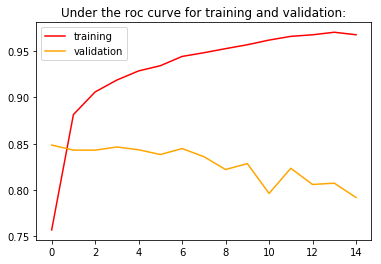

In [66]:
auroc = history.history['auroc']
val_auroc = history.history['val_auroc']
plt.plot(range(epoches), auroc, color='red', label='training')
plt.plot(range(epoches), val_auroc, color='orange', label='validation')
plt.title('Under the roc curve for training and validation:')
plt.legend(loc='best')

Vidimo da bi broj epoha definitivno trebao da se smanji na 5,6

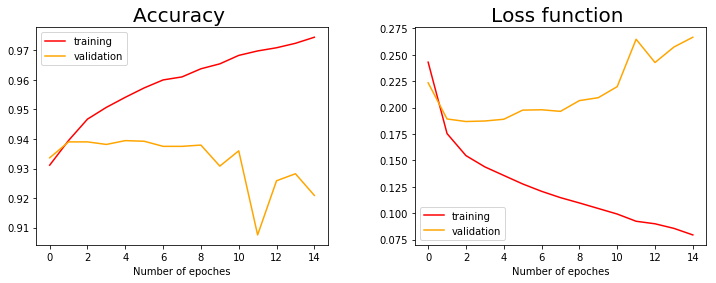

In [84]:
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
ax1.set_title('Accuracy ', fontdict={'fontsize':20})
ax2.set_title('Loss function ', fontdict={'fontsize':20})

acc = history.history['acc']
val_acc = history.history['val_acc']
ax1.plot(range(epoches), acc, color='red', label='training')
ax1.plot(range(epoches), val_acc, color='orange', label='validation')
ax1.legend(loc='best')
ax1.set_xlabel('Number of epoches')

loss = history.history['loss']
val_loss = history.history['val_loss']
ax2.plot(range(epoches), loss, color='red', label='training')
ax2.plot(range(epoches), val_loss, color='orange', label='validation')
ax2.legend(loc='best')
ax2.set_xlabel('Number of epoches')

plt.subplots_adjust(wspace=0.3)

In [24]:
K.clear_session()   ### Destroys the current TF graph and creates a new one

# LSTM (epochs = 6)

In [29]:
epoches = 6
batch_size = 128

# treniranje mreze traje nesto duze
start = time.time()

history = model.fit(x_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Train on 18559 samples, validate on 4640 samples
Epoch 1/6
18559/18559 [==============================] - 22s 1ms/step - loss: 0.2369 - acc: 0.9293 - auroc: 0.7447 - val_loss: 0.1978 - val_acc: 0.9338 - val_auroc: 0.8404
Epoch 2/6
18559/18559 [==============================] - 21s 1ms/step - loss: 0.1726 - acc: 0.9402 - auroc: 0.8802 - val_loss: 0.1889 - val_acc: 0.9384 - val_auroc: 0.8446
Epoch 3/6
18559/18559 [==============================] - 22s 1ms/step - loss: 0.1533 - acc: 0.9467 - auroc: 0.9063 - val_loss: 0.1857 - val_acc: 0.9394 - val_auroc: 0.8516
Epoch 4/6
18559/18559 [==============================] - 22s 1ms/step - loss: 0.1433 - acc: 0.9507 - auroc: 0.9220 - val_loss: 0.1981 - val_acc: 0.9325 - val_auroc: 0.8503
Epoch 5/6
18559/18559 [==============================] - 23s 1ms/step - loss: 0.1350 - acc: 0.9533 - auroc: 0.9295 - val_loss: 0.2127 - val_acc: 0.9226 - val_auroc: 0.8486
Epoch 6/6
18559/18559 [==============================] - 23s 1ms/step - loss: 0.1284 - acc:

In [30]:
y_train_predicted = model.predict(x_train)
y_test_predicted = model.predict(x_test)

In [31]:
results_report(model, 'Arhitectur:LSTM(6 epoches), embedding_dim=64, optimizator=rmsprop.',
               y_train, y_train_predicted, y_test, y_test_predicted)

Arhitectur:LSTM(6 epoches), embedding_dim=64, optimizator=rmsprop.
Results: 

Train acc: 95.37%, Test acc: 93.31%
Train ROC: 92.7388611%, test ROC: 85.6963729%
Confusion matrix(for threshold 0.5): 
Train set: 
[[  828   720]
 [  355 21296]]
Test set: 
[[  281   482]
 [  283 10381]]


In [32]:
K.clear_session()

# Find hyperparametar in LSTM

Pokusacemo da vidimo koji optimizacioni algoritam bi bilo najbolje da koristimo kao i najbolju dimenziju embedding sloja

In [35]:
best_ROC = 0
best_acc = 0
best_optimizer = None
best_ED = None

optimizer = {'rmsprop', 'Adam', 'SGD'}
embedding_dimensionality = [16,32,64,128,256]

epoches = 6
batch_size = 128
max_features = 10000
maxlen = 50

In [11]:
start = time.time()

for ed in embedding_dimensionality:
    for o in optimizer:
                 
        embedding_DIM = ed
            
        model = Sequential()
        model.add(Embedding(max_features, embedding_DIM, input_length=maxlen))
        model.add(LSTM(128))  # probati sa LSTM(units=128, dropout=0.2)
        model.add(Dense(1, activation='sigmoid'))
            
        model.compile(optimizer=o, loss='binary_crossentropy', metrics=['acc'])
            
        history = model.fit(x_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)
            
        y_test_predicted = model.predict(x_test)
            
        ROC = roc_auc_score(y_test, y_test_predicted)
        acc = accuracy_score(y_test, [1 if x > 0.5 else 0 for x in y_test_predicted])
            
        if (ROC>best_ROC) and (acc+0.5>best_acc):   # ROC metrika nam je priorite u odnosu na accuracy metriku.
            best_ROC = ROC
            best_acc = acc
            best_optimizer = o
            best_ED = ed
                
end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 18559 samples, validate on 4640 samples
Epoch 1/6
18559/18559 [==============================] - 18s 981us/step - loss: 0.2551 - acc: 0.9299 - val_loss: 0.2409 - val_acc: 0.9332
Epoch 2/6
18559/18559 [==============================] - 17s 903us/step - loss: 0.1991 - acc: 0.9350 - val_loss: 0.1944 - val_acc: 0.9351
Epoch 3/6
18559/18559 [==============================] - 17s 937us/step - loss: 0.1759 - acc: 0.9372 - val_loss: 0.1880 - val_acc: 0.9397
Epoch 4/6
18559/18559 [==============================] - 18s 969us/step - loss: 0.1548 - acc: 0.9456 - val_loss: 0.1883 - val_acc: 0.9366
Epoch 5/6
18559/18559 [==============================] - 18s 962us/step - loss: 0.1482 - acc: 0.9479 - val_loss: 0.1975 - val_acc: 0.9351
Epoch 6/6
18559/18559 [==============================] - 18s 955us/step - loss: 0.1426 - acc: 0.9501 - val_loss: 0.1904 - val_acc: 0.9388
Tra

In [13]:
print(f"Best embedding dimensionality : {best_ED}, \nBest optimizator : {best_optimizer}")  

Best embedding dimensionality : 32, 
Best optimizator : rmsprop


In [12]:
embedding_DIM = 32

model = Sequential()
model.add(Embedding(max_features, embedding_DIM, input_length=maxlen))
model.add(LSTM(128)) # slicno je ako se stavi dropout=0.2
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', auroc])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [14]:
epoches = 6
batch_size = 128

# treniranje mreze traje nesto duze
start = time.time()

history = model.fit(x_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Instructions for updating:
Use tf.cast instead.
Train on 18559 samples, validate on 4640 samples
Epoch 1/6
18559/18559 [==============================] - 19s 1ms/step - loss: 0.2531 - acc: 0.9305 - auroc: 0.7438 - val_loss: 0.2339 - val_acc: 0.9332 - val_auroc: 0.8054
Epoch 2/6
18559/18559 [==============================] - 18s 968us/step - loss: 0.1867 - acc: 0.9373 - auroc: 0.8689 - val_loss: 0.2043 - val_acc: 0.9360 - val_auroc: 0.8372
Epoch 3/6
18559/18559 [==============================] - 19s 1ms/step - loss: 0.1607 - acc: 0.9440 - auroc: 0.9017 - val_loss: 0.1893 - val_acc: 0.9384 - val_auroc: 0.8416
Epoch 4/6
18559/18559 [==============================] - 20s 1ms/step - loss: 0.1505 - acc: 0.9488 - auroc: 0.9096 - val_loss: 0.1916 - val_acc: 0.9381 - val_auroc: 0.8475
Epoch 5/6
18559/18559 [==============================] - 20s 1ms/step - loss: 0.1431 - acc: 0.9499 - auroc: 0.9189 - val_loss: 0.1915 - val_acc: 0.9343 - val_auroc: 0.8450
Epoch 6/6
18559/18559 [==================

In [15]:
y_train_predicted = model.predict(x_train)
y_test_predicted = model.predict(x_test)

In [16]:
results_report(model, 'Arhitectur:LSTM(6 epoches), embedding_dim=32, optimizator=rmsprop.',
               y_train, y_train_predicted, y_test, y_test_predicted)

Arhitectur:LSTM(6 epoches), embedding_dim=32, optimizator=rmsprop.
Results: 

Train acc: 95.34%, Test acc: 93.60%
Train ROC: 91.9489429%, test ROC: 85.9408291%
Confusion matrix(for threshold 0.5): 
Train set: 
[[  738   810]
 [  270 21381]]
Test set: 
[[  249   514]
 [  217 10447]]


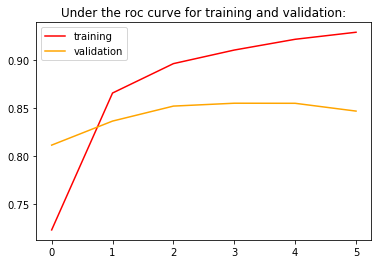

In [15]:
auroc = history.history['auroc']
val_auroc = history.history['val_auroc']
plt.plot(range(epoches), auroc, color='red', label='training')
plt.plot(range(epoches), val_auroc, color='orange', label='validation')
plt.title('Under the roc curve for training and validation:')
plt.legend(loc='best')

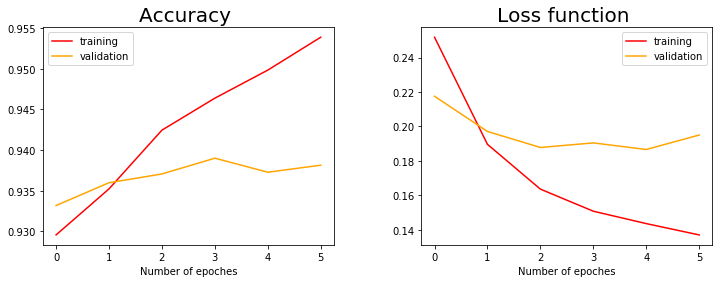

In [16]:
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
ax1.set_title('Accuracy ', fontdict={'fontsize':20})
ax2.set_title('Loss function ', fontdict={'fontsize':20})

acc = history.history['acc']
val_acc = history.history['val_acc']
ax1.plot(range(epoches), acc, color='red', label='training')
ax1.plot(range(epoches), val_acc, color='orange', label='validation')
ax1.legend(loc='best')
ax1.set_xlabel('Number of epoches')

loss = history.history['loss']
val_loss = history.history['val_loss']
ax2.plot(range(epoches), loss, color='red', label='training')
ax2.plot(range(epoches), val_loss, color='orange', label='validation')
ax2.legend(loc='best')
ax2.set_xlabel('Number of epoches')

plt.subplots_adjust(wspace=0.3)

Dobili smo Test Roc = 85.95% , sto uopste nije lose, iako smo mozda malo vise ocekivali od neuronski mreza

In [17]:
K.clear_session()

# LSTM pomocu Word2Vec

Word2Vec je drugi nacin gradjenja neuronske mreze kod problema sentiment analize.

Umesto da treniramo embeding sloj (kroz neuronsku mrezu), mi mozemo prvo odvojeno da naucimo vektorsku reprezentaciju reci 
(iskoristimo word2vec) i onda je prosledimo embeding sloju.
Ovaj nacin dozvoljava da koristimo bilo koji drugi pre-trenirani model za "word embedding" i takodje skratimo vreme treniranja neuronske mreze.

"Word Embedding" je reprezentacija teksta gde reci sa slicnim znacenjem imaju slicnu reprezentaciju.
Drugim recima, reci su predstavljene u koordinatnom sistemu gde su slicne reci(na osnovu ulaznog korpusa), smestene u slican deo prostora.
 
Mi cemo koristiti gensim implementaciju za word2vec

In [9]:
x_train_v2w, x_test_v2w, y_train_v2w, y_test_v2w = model_selection.train_test_split(x, y, test_size=0.33, random_state=42, stratify=y)

In [10]:
v2w_tokenizer = Tokenizer() # bez max_features = 10 000
v2w_tokenizer.fit_on_texts(x)

In [11]:
x_trainV2W = np.array(v2w_tokenizer.texts_to_sequences(x_train_v2w))
x_testV2W = np.array(v2w_tokenizer.texts_to_sequences(x_test_v2w))

Kao pre, pravimo sekvence istih duzina..

In [12]:
maxlen = 50

x_trainV2W = pad_sequences(x_trainV2W, maxlen = maxlen)
x_testV2W = pad_sequences(x_testV2W, maxlen = maxlen)

In [4]:
# Pravimo model i postavljamo vrednosti za razlicite parametre
Embedding_DIM = 32  # Word vector dimensionality
min_word_count = 1  # Minimum word count
num_workers = 4     # Number of parallel threads
context = 5         # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

In [32]:
start = time.time()

print("Training model....")
model = word2vec.Word2Vec(x, size=Embedding_DIM, window=context,
                          workers=num_workers, min_count=min_word_count, sample=downsampling)

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Training model....


C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


Vreme obucavanja je 19.58 minuta


In [33]:
#  Istampace 10 najslicnijih reci datoj reci.
model.wv.most_similar("good")

[('decent', 0.8882670402526855),
 ('amazing', 0.8830348253250122),
 ('excellent', 0.8727772235870361),
 ('fantastic', 0.8617746233940125),
 ('great', 0.8543925881385803),
 ('awesome', 0.8283018469810486),
 ('nice', 0.825795590877533),
 ('cool', 0.8183963298797607),
 ('ok', 0.8086968660354614),
 ('complaint', 0.7804789543151855)]

In [35]:
# Istampace rec koja nije u kontekstu
model.wv.doesnt_match("man woman dog child kitchen".split())

'child'

In [36]:
# Sacuvamo model u txt fajlu sa svim koeficijentima.
filename = 'Amazon_Sentiment_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename)

In [23]:
import os

# pravimo recnik koji sadrzi reci i koeficijente dobijene pomocu word2vec za datu rec
# pomocu tog recnika cemo napraviti matricu koju cemo proslediti neuronskoj mrezi...
embeddings_index = {}
f = open(os.path.join('', 'Amazon_Sentiment_embedding_word2vec.txt'), encoding= "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [24]:
word_index = v2w_tokenizer.word_index
print(f'Nasli smo {len(word_index)} jedinstvenih reci')

Nasli smo 11691 jedinstvenih reci


In [25]:
# Pravimo matricu koju prosledjujemo neuronskoj mrezi
# U svakoj vrsti se nalazi jedinstvena rec i koeficijenti dobijeni za nju pomocu word2vec
num_words = len(word_index)+1
embeddings_matrix = np.zeros((num_words, Embedding_DIM))

for word,i in word_index.items():
    if i>num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Reci koje nisu nadjene u embedding_index-u ce biti sve nule u mrezi..
        embeddings_matrix[i] = embedding_vector

In [33]:
model = Sequential()
model.add(Embedding(num_words, Embedding_DIM, embeddings_initializer=Constant(embeddings_matrix),
                    input_length=maxlen, trainable=False)) 
# postavljamo trainable=False da bismo sprecili da tezine budu azurirane tokom treninga
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            374144    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 456,705
Trainable params: 82,561
Non-trainable params: 374,144
_________________________________________________________________


Ukupno parametara = 456,705 , ali trainable parametara = 82,561. 

S obzirom da model koristi pre-treniran word2vec, ima dosta manji broj parametara za treniranje, zbog cega bi trebao brze da istrenira.

In [35]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', auroc])

In [29]:
epoches = 10
batch_size = 128

start = time.time()

history = model.fit(x_trainV2W, y_train_v2w, epochs=epoches, batch_size=batch_size, validation_split=0.2)

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Train on 18559 samples, validate on 4640 samples
Epoch 1/10
18559/18559 [==============================] - 18s 988us/step - loss: 0.2168 - acc: 0.9274 - auroc: 0.7820 - val_loss: 0.2052 - val_acc: 0.9330 - val_auroc: 0.8079
Epoch 2/10
18559/18559 [==============================] - 17s 938us/step - loss: 0.1978 - acc: 0.9336 - auroc: 0.8335 - val_loss: 0.2114 - val_acc: 0.9334 - val_auroc: 0.8140
Epoch 3/10
18559/18559 [==============================] - 17s 937us/step - loss: 0.1913 - acc: 0.9339 - auroc: 0.8474 - val_loss: 0.2007 - val_acc: 0.9323 - val_auroc: 0.8245
Epoch 4/10
18559/18559 [==============================] - 18s 970us/step - loss: 0.1861 - acc: 0.9343 - auroc: 0.8544 - val_loss: 0.1999 - val_acc: 0.9330 - val_auroc: 0.8264
Epoch 5/10
18559/18559 [==============================] - 18s 974us/step - loss: 0.1813 - acc: 0.9361 - auroc: 0.8661 - val_loss: 0.1986 - val_acc: 0.9334 - val_auroc: 0.8333
Epoch 6/10
18559/18559 [==============================] - 18s 984us/step - l

In [30]:
y_train_predicted = model.predict(x_trainV2W)
y_test_predicted = model.predict(x_testV2W)

In [31]:
results_report(model, 'Arhitectur:LSTM(10 epoches) with Word2Vec algoritham, embedding_dim=32, optimizator=rmsprop.',
               y_train_v2w, y_train_predicted, y_test_v2w, y_test_predicted)

Arhitectur:LSTM(10 epoches) with Word2Vec algoritham, embedding_dim=32, optimizator=rmsprop.
Results: 

Train acc: 93.97%, Test acc: 92.22%
Train ROC: 90.4198170%, test ROC: 84.6128595%
Confusion matrix(for threshold 0.5): 
Train set: 
[[  675   873]
 [  525 21126]]
Test set: 
[[  239   524]
 [  365 10299]]


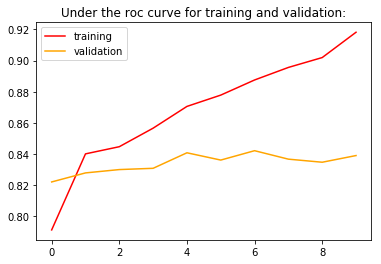

In [59]:
auroc = history.history['auroc']
val_auroc = history.history['val_auroc']
plt.plot(range(epoches), auroc, color='red', label='training')
plt.plot(range(epoches), val_auroc, color='orange', label='validation')
plt.title('Under the roc curve for training and validation:')
plt.legend(loc='best')

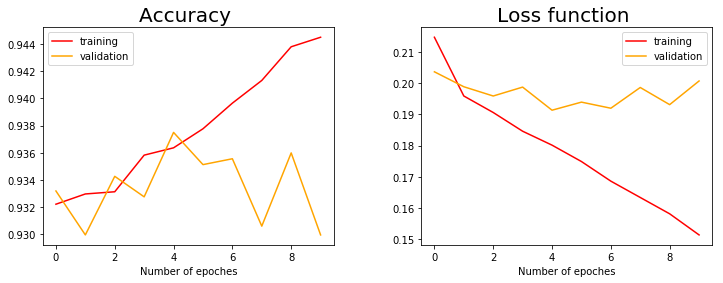

In [60]:
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
ax1.set_title('Accuracy ', fontdict={'fontsize':20})
ax2.set_title('Loss function ', fontdict={'fontsize':20})

acc = history.history['acc']
val_acc = history.history['val_acc']
ax1.plot(range(epoches), acc, color='red', label='training')
ax1.plot(range(epoches), val_acc, color='orange', label='validation')
ax1.legend(loc='best')
ax1.set_xlabel('Number of epoches')

loss = history.history['loss']
val_loss = history.history['val_loss']
ax2.plot(range(epoches), loss, color='red', label='training')
ax2.plot(range(epoches), val_loss, color='orange', label='validation')
ax2.legend(loc='best')
ax2.set_xlabel('Number of epoches')

plt.subplots_adjust(wspace=0.3)

Vidimo da bi broje epoch-a trebao biti 6 ili 8 npr, ali mi bismo stavili 6 jer posle toga cini se da lagano staje sa ucenjem...

In [32]:
K.clear_session()

In [36]:
epoches = 6
batch_size = 128

# treniranje mreze traje nesto duze
start = time.time()

history = model.fit(x_trainV2W, y_train_v2w, epochs=epoches, batch_size=batch_size, validation_split=0.2)

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Train on 18559 samples, validate on 4640 samples
Epoch 1/6
18559/18559 [==============================] - 18s 957us/step - loss: 0.2144 - acc: 0.9292 - auroc: 0.7942 - val_loss: 0.2138 - val_acc: 0.9308 - val_auroc: 0.8125
Epoch 2/6
18559/18559 [==============================] - 17s 901us/step - loss: 0.1965 - acc: 0.9326 - auroc: 0.8360 - val_loss: 0.1975 - val_acc: 0.9330 - val_auroc: 0.8269
Epoch 3/6
18559/18559 [==============================] - 17s 940us/step - loss: 0.1922 - acc: 0.9326 - auroc: 0.8476 - val_loss: 0.1963 - val_acc: 0.9356 - val_auroc: 0.8283
Epoch 4/6
18559/18559 [==============================] - 18s 976us/step - loss: 0.1855 - acc: 0.9351 - auroc: 0.8558 - val_loss: 0.1942 - val_acc: 0.9358 - val_auroc: 0.8340
Epoch 5/6
18559/18559 [==============================] - 18s 973us/step - loss: 0.1793 - acc: 0.9360 - auroc: 0.8714 - val_loss: 0.1946 - val_acc: 0.9353 - val_auroc: 0.8314
Epoch 6/6
18559/18559 [==============================] - 18s 974us/step - loss: 0

In [37]:
y_train_predicted = model.predict(x_trainV2W)
y_test_predicted = model.predict(x_testV2W)

In [38]:
results_report(model, 'Arhitectur:LSTM(6 epoches) with Word2Vec algoritham, embedding_dim=32, optimizator=rmsprop.',
               y_train_v2w, y_train_predicted, y_test_v2w, y_test_predicted)

Arhitectur:LSTM(6 epoches) with Word2Vec algoritham, embedding_dim=32, optimizator=rmsprop.
Results: 

Train acc: 93.99%, Test acc: 93.34%
Train ROC: 87.5272678%, test ROC: 84.0464703%
Confusion matrix(for threshold 0.5): 
Train set: 
[[  311  1237]
 [  158 21493]]
Test set: 
[[  103   660]
 [  101 10563]]


test ROC = 84.04% nam je najbolja tacnost pri primenjivanju word2vec kod RNN-a 

Da probamo neke druge parametre da prosledimo word2vec-u, mozda budu bolji rezultati...

In [13]:
# Creating the model and setting values for the various parameters
Embedding_DIM = 32  # Word vector dimensionality
min_word_count = 3  # Minimum word count
num_workers = 4     # Number of parallel threads
context = 4         # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words
learning_rate = 1e-2

In [9]:
start = time.time()

print("Training model....")
model = word2vec.Word2Vec(x, size=Embedding_DIM, window=context, alpha=learning_rate,
                          workers=num_workers, min_count=min_word_count, sample=downsampling)

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Training model....


C:\Users\vladimir.lukovic\AppData\Roaming\Python\Python37\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


Vreme obucavanja je 16.49 minuta


In [15]:
# Sacuvamo model u txt fajlu sa svim koeficijentima.
filename = 'Amazon_Sentiment_embedding_word2vec_different_param.txt'
model.wv.save_word2vec_format(filename)

In [11]:
#  Istampace 10 najslicnijih reci datoj reci.
model.wv.most_similar("good")

[('excellent', 0.9865986704826355),
 ('nice', 0.9678224325180054),
 ('amazing', 0.96621173620224),
 ('overall', 0.96002197265625),
 ('well', 0.955249547958374),
 ('pretty', 0.9542925357818604),
 ('fast', 0.9542902708053589),
 ('resolution', 0.9537312984466553),
 ('decent', 0.9528672099113464),
 ('low', 0.9516057968139648)]

In [16]:
import os

# pravimo recnik koji sadrzi reci i koeficijente dobijene pomocu word2vec za datu rec
# pomocu tog recnika cemo napraviti matricu koju cemo proslediti neuronskoj mrezi...
embeddings_index = {}
f = open(os.path.join('', 'Amazon_Sentiment_embedding_word2vec_different_param.txt'), encoding= "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [17]:
word_index = v2w_tokenizer.word_index
print(f'Nasli smo {len(word_index)} jedinstvenih reci')

Nasli smo 11691 jedinstvenih reci


In [18]:
# Pravimo matricu koju prosledjujemo neuronskoj mrezi
# U svakoj vrsti se nalazi jedinstvena rec i koeficijenti dobijeni za nju pomocu word2vec
num_words = len(word_index)+1
embeddings_matrix = np.zeros((num_words, Embedding_DIM))

for word,i in word_index.items():
    if i>num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Reci koje nisu nadjene u embedding_index-u ce biti sve nule u mrezi..
        embeddings_matrix[i] = embedding_vector

In [19]:
model = Sequential()
model.add(Embedding(num_words, Embedding_DIM, embeddings_initializer=Constant(embeddings_matrix),
                    input_length=maxlen, trainable=False)) 
# Note that we set trainable=False to prevent the weights from being updated during training.
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            374144    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 456,705
Trainable params: 82,561
Non-trainable params: 374,144
_________________________________________________________________


In [21]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', auroc])

epoches = 6
batch_size = 128

# treniranje mreze traje nesto duze
start = time.time()

history = model.fit(x_trainV2W, y_train_v2w, epochs=epoches, batch_size=batch_size, validation_split=0.2)

end = time.time()
print('Vreme obucavanja je {0:.2f} minuta'.format((end - start)/60))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Train on 18559 samples, validate on 4640 samples
Epoch 1/6
18559/18559 [==============================] - 19s 1ms/step - loss: 0.2369 - acc: 0.9286 - auroc: 0.7074 - val_loss: 0.2259 - val_acc: 0.9332 - val_auroc: 0.7385
Epoch 2/6
18559/18559 [==============================] - 18s 962us/step - loss: 0.2240 - acc: 0.9333 - auroc: 0.7480 - val_loss: 0.2219 - val_acc: 0.9332 - val_auroc: 0.7529
Epoch 3/6
18559/18559 [==============================] - 16s 877us/step - loss: 0.2200 - acc: 0.9334 - auroc: 0.7598 - val_

In [22]:
y_train_predicted = model.predict(x_trainV2W)
y_test_predicted = model.predict(x_testV2W)

In [23]:
results_report(model, 'Arhitectur:LSTM(6 epoches) with Word2Vec algoritham, embedding_dim=32, optimizator=rmsprop.',
               y_train_v2w, y_train_predicted, y_test_v2w, y_test_predicted)

Arhitectur:LSTM(6 epoches) with Word2Vec algoritham, embedding_dim=32, optimizator=rmsprop.
Results: 

Train acc: 93.34%, Test acc: 93.29%
Train ROC: 79.0802148%, test ROC: 77.7816423%
Confusion matrix(for threshold 0.5): 
Train set: 
[[   23  1525]
 [   20 21631]]
Test set: 
[[    8   755]
 [   12 10652]]


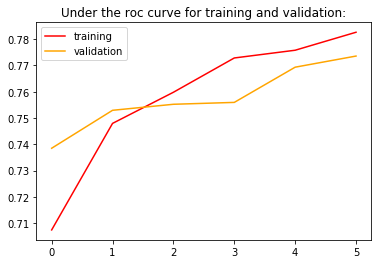

In [24]:
auroc = history.history['auroc']
val_auroc = history.history['val_auroc']
plt.plot(range(epoches), auroc, color='red', label='training')
plt.plot(range(epoches), val_auroc, color='orange', label='validation')
plt.title('Under the roc curve for training and validation:')
plt.legend(loc='best')

Nije se nesto pokazala ova arhitektura word2vec-a. Bolje rezultate nam daje prethodna arhitektura.. 

In [21]:
K.clear_session()